# RMSprop optimizer

RMSprop (Root Mean Square Propagation) is an optimization algorithm commonly used in training artificial neural networks (ANNs). It is particularly effective in scenarios where other optimization algorithms like vanilla stochastic gradient descent (SGD) may struggle due to problems such as vanishing or exploding gradients.

## Details of RMSprop Algorithm

RMSprop is an adaptive learning rate optimization algorithm proposed by Geoffrey Hinton in his course on Neural Networks for Machine Learning. The algorithm is designed to adaptively adjust the learning rates for different parameters during training.

Summary of how RMSprop works:

1. Compute Squared Gradients: RMSprop maintains a moving average of the squared gradients for each parameter. This is similar to AdaGrad but with a decaying average.

2. Update Parameters: The update rule adjusts the learning rate for each parameter based on the average of the squared gradients.

3. Adaptive Learning Rates: RMSprop divides the learning rate by the square root of the exponentially decaying average of squared gradients for each parameter. This helps to normalize the learning rates and overcome the problems of vanishing or exploding gradients.


## Pros of RMSprop optimizer

1. Adaptive Learning Rates: RMSprop adapts the learning rates for each parameter individually based on the magnitude of their gradients. This helps converge faster and more efficiently, especially in deep neural networks.

2. Stability: It helps to stabilize the learning process by mitigating the issues of vanishing and exploding gradients.

3. Simple Implementation: RMSprop is relatively easy to implement and widely used in practice.

## Cons of RMSprop optimizer

1. Hyperparameter Sensitivity: RMSprop, like other adaptive methods, has hyperparameters that need to be tuned, such as the learning rate and the decay rate. Improper tuning can lead to suboptimal performance.

2. Memory Usage: RMSprop maintains a moving average of squared gradients for each parameter, which can require additional memory, especially for large models with many parameters.


## References
- https://keras.io/api/optimizers/rmsprop/

In [9]:
from fashionmnist_model import FMM
import tensorflow as tf

In [10]:
# Load and preprocess the data
X_train, y_train, X_test, y_test = FMM.load_data()

In [11]:
# Reshape the data
X_train, X_test = FMM.reshape_data(X_train, X_test)

In [12]:
optimizer = tf.keras.optimizers.RMSprop()
model = FMM.create_model_v2()
print(f"Training with {optimizer.__class__.__name__} optimizer...")
history = FMM.compile_and_train(
    model, X_train, y_train, optimizer
)

Training with RMSprop optimizer...
Epoch 1/30
480/480 [==============================] - 2s 3ms/step - loss: 0.7756 - accuracy: 0.7410 - val_loss: 0.5169 - val_accuracy: 0.8094
Epoch 2/30
480/480 [==============================] - 1s 3ms/step - loss: 0.5291 - accuracy: 0.8211 - val_loss: 0.4205 - val_accuracy: 0.8497
Epoch 3/30
480/480 [==============================] - 1s 2ms/step - loss: 0.4797 - accuracy: 0.8362 - val_loss: 0.3895 - val_accuracy: 0.8605
Epoch 4/30
480/480 [==============================] - 1s 2ms/step - loss: 0.4506 - accuracy: 0.8469 - val_loss: 0.3928 - val_accuracy: 0.8582
Epoch 5/30
480/480 [==============================] - 1s 2ms/step - loss: 0.4275 - accuracy: 0.8546 - val_loss: 0.3987 - val_accuracy: 0.8573
Epoch 6/30
480/480 [==============================] - 1s 3ms/step - loss: 0.4146 - accuracy: 0.8597 - val_loss: 0.3675 - val_accuracy: 0.8694
Epoch 7/30
480/480 [==============================] - 1s 2ms/step - loss: 0.4068 - accuracy: 0.8612 - val_loss: 0

313/313 - 0s - loss: 0.3503 - accuracy: 0.8784 - 300ms/epoch - 958us/step

Training accuracy : 0.8909791707992554
Validation accuracy : 0.8881666660308838
Loss : 0.35027778148651123
Accuracy : 0.8784000277519226



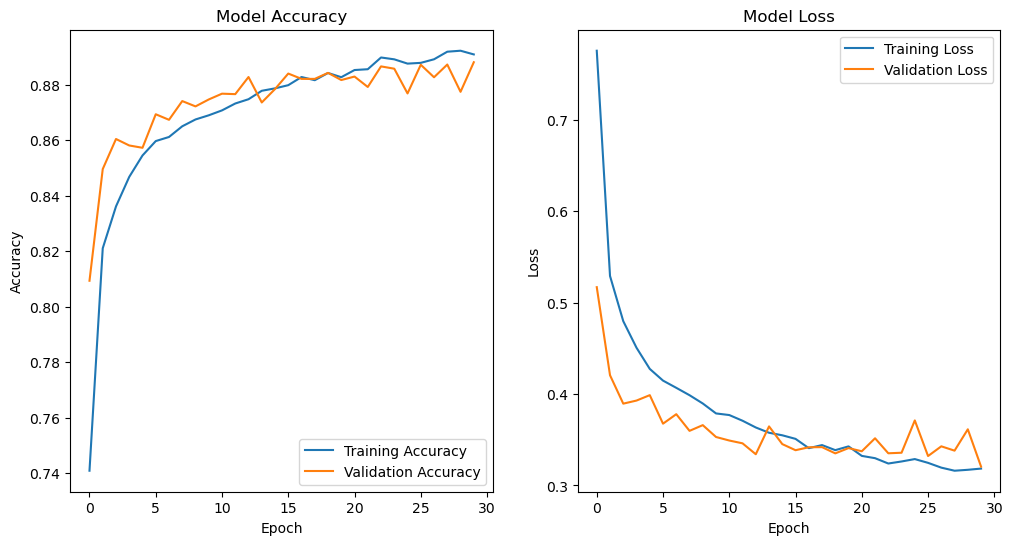

In [13]:
FMM.evaluate(model, X_test, y_test, history)
FMM.plot_history(history)

The trend shows that the training loss is increasing over time, while the validation loss is decreasing. This suggests that the model is overfitting the training data.

# Hyperparameter tunning

In [ ]:
import ray
from ray import tune, train

# ! pip install -U "ray[data,train,tune,serve]"

In [ ]:
ray.init()

In [ ]:
# Define a function to train the model
def train_model(config):
    from fashionmnist_model import FMM
    import tensorflow as tf
    
    X_train, y_train, X_test, y_test = FMM.load_data()
    X_train, X_test = FMM.reshape_data(X_train, X_test)

    optimizer = tf.keras.optimizers.RMSprop(
        learning_rate=config["learning_rate"],
        rho=config["rho"],
        epsilon=config["epsilon"],
        weight_decay=config["weight_decay"],
    )

    model = FMM.create_model_v2()
    history = FMM.compile_and_train(
        model, X_train, y_train, optimizer
    )
    
    loss, accuracy, _, _ = FMM.evaluate(model, X_test, y_test, history)

    train.report({"accuracy": accuracy, "loss": loss, **config})

In [ ]:
search_space = {
    "learning_rate": tune.grid_search([0.001, 0.0005, 0.0001]),
    "rho": tune.grid_search([0.9, 0.95, 0.99]),
    "epsilon": tune.grid_search([1e-8, 1e-7, 1e-6]),
    "weight_decay": tune.grid_search([1e-6, 1e-5, 1e-4]),
}

In [ ]:
# Run hyperparameter tuning
analysis = tune.run(
    train_model,
    config=search_space,
    metric="accuracy",
    mode="max",
)

In [ ]:
ray.shutdown()

In [ ]:
FMM.plot_analysis_results(analysis, x_axis="learning_rate", y_axis="accuracy")

In [ ]:
# Print the best hyperparameters and results
best_config = analysis.best_config
print("Best hyperparameters:", best_config)
print("Best accuracy:", analysis.best_result["accuracy"])